In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
from scipy import stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Load the data
d = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
d = d[d.age >= 18]
d['weight_c'] = d.weight - d.weight.mean()

##### 4E1
Line 1 is the likelihood, the other lines are priors

##### 4E2
2 parameters

##### 4E3
see overthinking box in page 83

##### 4E4
Line 2

##### 4E1
There are 3 parameters



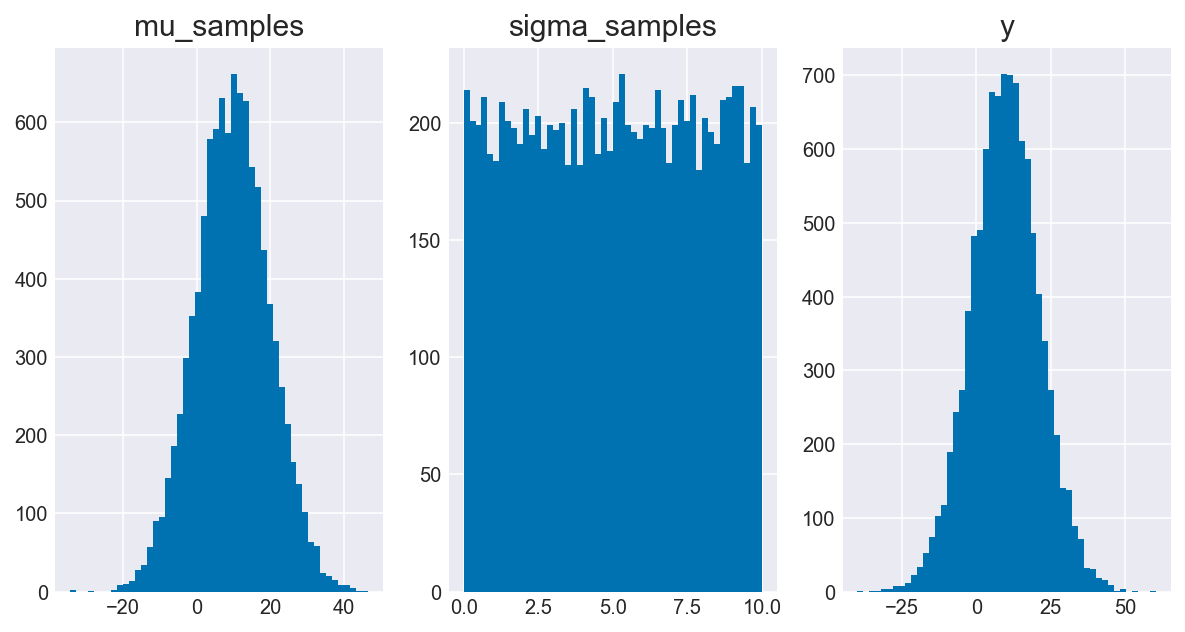

In [51]:
# 4M1
# Simulating priors
mu_samples = np.random.normal(10, 10, size=10000)
sigma_samples = np.random.uniform(0,10, size=10000)
y = np.random.normal(mu_samples, sigma_samples)

_, axes = plt.subplots(1,3, figsize=(10,5))
axes[0].hist(mu_samples, bins=50)
axes[1].hist(sigma_samples, bins=50)
axes[2].hist(y, bins=50)
axes[0].set_title('mu_samples', fontsize=15)
axes[1].set_title('sigma_samples', fontsize=15)
axes[2].set_title('y', fontsize=15);


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y, sigma, mu]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:04<00:00, 998.12draws/s] 
There were 72 divergences after tuning. Increase `target_accept` or reparameterize.
There were 78 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


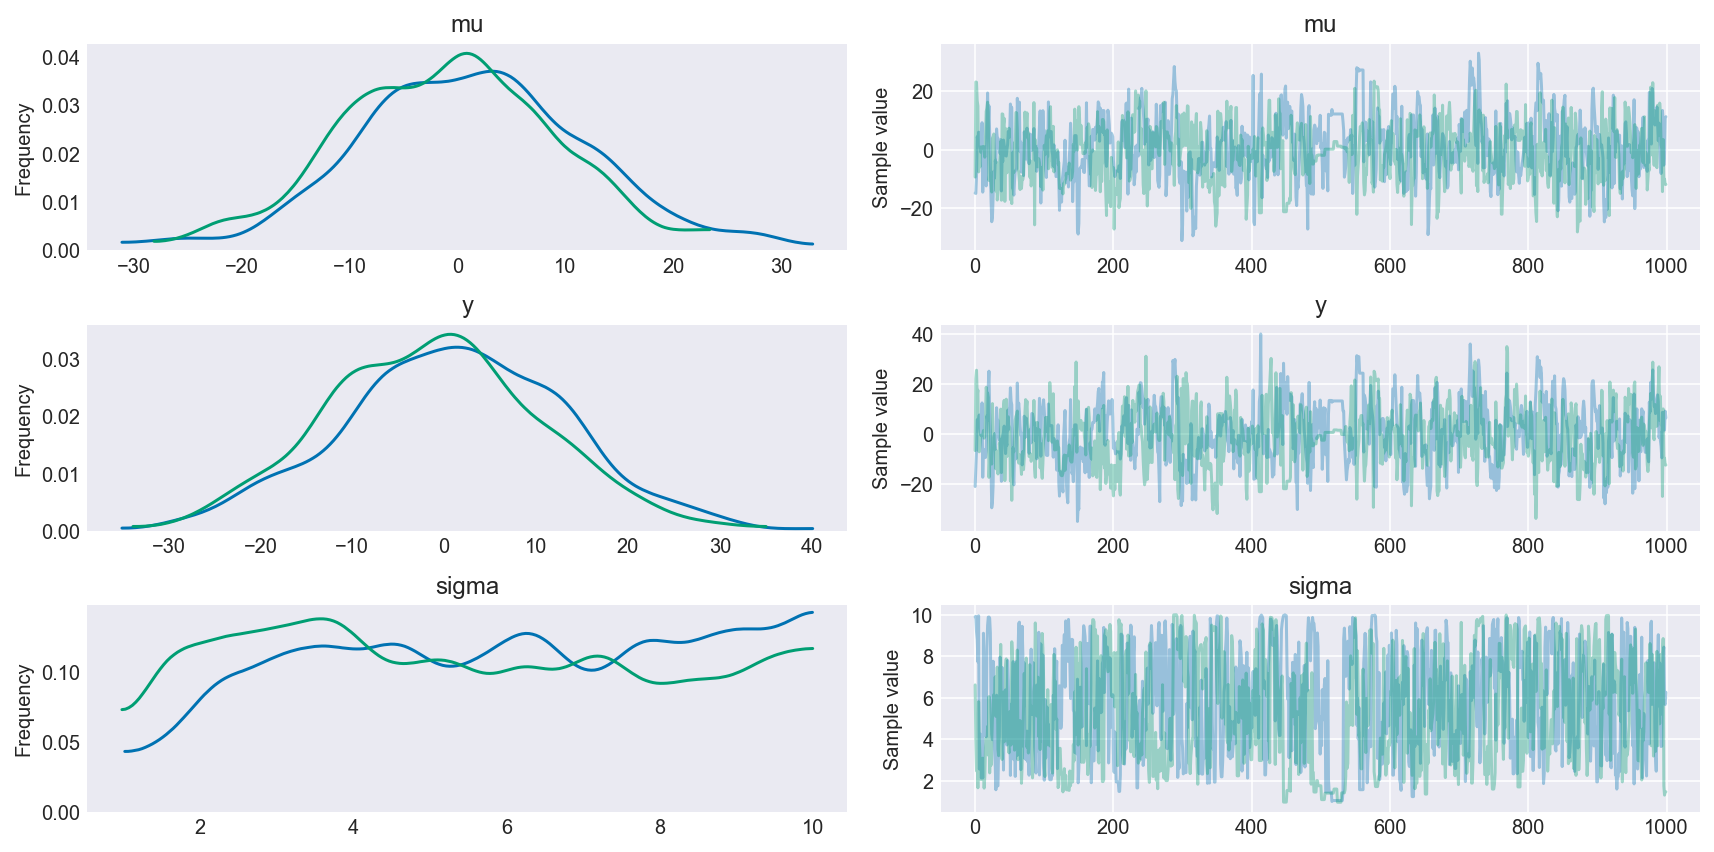

In [56]:
# 4M2
# Since we're already using pymc3, we'll translate this into a pymc3 model
with pm.Model() as m_4M2:
    mu=pm.Normal('mu',mu=0,sd=10)
    sigma=pm.Uniform('sigma',lower=0, upper=10)
    y=pm.Normal('y',mu=mu,sd=sigma)
    trace_4M2=pm.sample(1000,tune=1000)

pm.traceplot(trace_4M2); 

##### 4M3
y~Normal(mu,sigma)  
mu = alpha + beta*Xi  
alpha ~ Normal(0,50)  
beta ~ Uniform(0,10)  
sigma ~ Unifrom(0,50)  


##### 4M4

height ~ Normal (mu,sigma)

mu = alpha + beta * year[i]  

alpha ~ Normal(140,20)
beta ~ Normal(5,3) 
sigma ~ Uniform(0,50)  
  
Alpha is still the mean height. With no further information, we just pick a prior that seems plausible.  
Beta is now [year] and not [weight]. The prior I have, Normal(5,3), means on avg the students will grow 5CM per year.  

##### 4M5
alpha ~ Normal(120,20)
beta ~ Normal(5,2)

we center the mean at 120cm. And make beta a bit smaller so that 5-2sd is still >0

##### 4M6
sigma ~ Uniform(0,8)
we cap the upper bound of SD at 8, since variance is never more than 64cm



In [38]:
# 4H1
weight = (46.95, 43.72, 64.78, 32.59, 54.63)

# Here we create our model, since we didn't center the weight sequence, we don't use the centered value
# We're still only using adults for modeling
with pm.Model() as m_4h1:
    alpha = pm.Normal('alpha',mu=140,sd=30)
    beta = pm.Normal('beta',mu=0.5,sd=1)
    mu = pm.Deterministic('mu', alpha + beta * d.weight)
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    height=pm.Normal('height',mu=mu,sd=sigma,observed=d.height)
    trace_4h1=pm.sample(1000,tune=1000)

pm.summary(trace_4h1, alpha=.11,varnames=['alpha','beta','sigma']).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:08<00:00, 458.09draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,114.02,1.94,0.06,111.03,117.29,938.88,1.0
beta,0.90,0.04,0.00,0.83,0.97,948.33,1.0
sigma,5.10,0.19,0.01,4.83,5.42,971.01,1.0


In [40]:
# We first take get a list of samples for the specific weight and we push it our weight sequence through the model

mu_pred = np.zeros((len(weight), len(trace_4h1)*trace_4h1.nchains))
for i, w in enumerate(weight):
    mu_pred[i] = trace_4h1['alpha'] + trace_4h1['beta'] * w
    
# Based on the 
mean=[]
lower=[]
upper=[]
for w in mu_pred:
    mean.append(w.mean())
    lower.append(pm.hpd(w,alpha=0.11)[0])
    upper.append(pm.hpd(w,alpha=0.11)[1])

weight_df=pd.DataFrame({
    'individual':individual,
    'weight':weight,
    'mean':mean,
    'lower':lower,
    'upper':upper,
})
print(weight_df)

   individual  weight        mean       lower       upper
0           1   46.95  156.360561  155.904419  156.819588
1           2   43.72  153.447354  152.982073  153.899078
2           3   64.78  172.441819  171.008723  173.837645
3           4   32.59  143.408969  142.434303  144.371428
4           5   54.63  163.287317  162.516357  164.069873


In [49]:
# 4H2

d2 = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)
d2 = d2[d2.age < 18]

print(d2.head())
print(d2.shape)



    height     weight   age  male
18  121.92  19.617854  12.0     1
19  105.41  13.947954   8.0     0
20   86.36  10.489315   6.5     0
23  129.54  23.586784  13.0     1
24  109.22  15.989118   7.0     0
(192, 4)


mean

In [85]:
# Here is the model
with pm.Model() as m_4h2:
    alpha = pm.Normal('alpha',mu=108,sd=50)
    beta = pm.Normal('beta',mu=0.5,sd=1)
    mu = pm.Deterministic('mu', alpha + beta * d2.weight)
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    height=pm.Normal('height',mu=mu,sd=sigma,observed=d2.height)
    trace_4h2=pm.sample(1000,tune=1000)

pm.summary(trace_4h2, alpha=.11,varnames=['alpha','beta','sigma']).round(2)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:05<00:00, 734.17draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,58.44,1.40,0.05,56.17,60.57,673.82,1.0
beta,2.71,0.07,0.00,2.60,2.81,597.89,1.0
sigma,8.57,0.47,0.01,7.83,9.31,970.42,1.0




  0%|                                                                                          | 0/200 [00:00<?, ?it/s]

 78%|████████████████████████████████████████████████████████████▍                 | 155/200 [00:00<00:00, 1549.62it/s]

100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1492.54it/s]

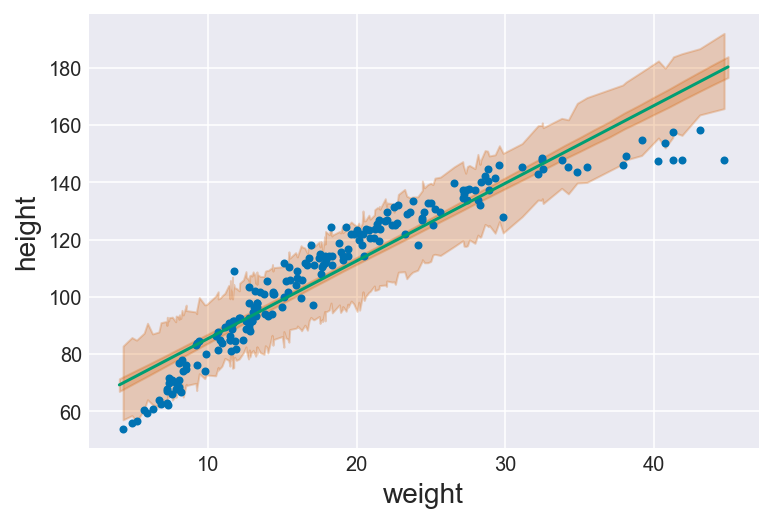

In [145]:
# Now we create the chart
# get mu mean and mu hpd
weight_seq = np.arange(int(d2.weight.min()), int(d2.weight.max())+2)

mu_pred_list=[]
for w in weight_seq:
    mu_pred_list.append(trace_4h2['alpha'] + trace_4h2['beta'] * w)
    
mu_mean_list=[x.mean() for x in mu_pred_list]
mu_hdp_y1=[pm.hpd(x)[0] for x in mu_pred_list]
mu_hdp_y2=[pm.hpd(x)[1] for x in mu_pred_list]

# get prediction hpd
idx = np.argsort(d2.weight.values)
height_pred = pm.sample_ppc(trace_4h2, 200, m_4h2)
height_pred_hpd = pm.hpd(height_pred['height'],alpha=0.11)
height_pred_hpd=height_pred_hpd[idx]
height_pred_hpd_y1=[x[0] for x in height_pred_hpd]
height_pred_hpd_y2=[x[1] for x in height_pred_hpd]
weight_sorted=d2.weight.values[idx]

# Plot
plt.plot(d2.weight, d2.height, '.') # raw data
plt.plot(weight_seq, mu_mean_list) # regression line
plt.fill_between(weight_seq, mu_hdp_y1, mu_hdp_y2, color='C2', alpha=0.25) # mean 0.5 hdpi
plt.fill_between(weight_sorted, height_pred_hpd_y1, height_pred_hpd_y2, color='C2', alpha=0.25) # pred 0.89 hdpi

plt.xlabel(d2.columns[1], fontsize=14)
plt.ylabel(d2.columns[0], fontsize=14);

# Part C
# The relationship between weight and height for kids is not a linear relationship.
# I would add in an age variable (next chapter) or add a polynomial term


In [35]:
# 4H3

d_f = pd.read_csv('../Data/Howell1.csv', sep=';', header=0)

# Model
# We add in np.log() for weight
# And match the prior to the book
with pm.Model() as m_4h3:
    alpha = pm.Normal('alpha',mu=178,sd=100)
    beta = pm.Normal('beta',mu=0,sd=100)
    mu = pm.Deterministic('mu', alpha + beta * np.log(d_f.weight))
    sigma=pm.Uniform('sigma',lower=0,upper=50)
    height=pm.Normal('height',mu=mu,sd=sigma,observed=d_f.height)
    trace_4h3=pm.sample(1000,tune=1000)

pm.summary(trace_4h3, alpha=.11,varnames=['alpha','beta','sigma']).round(2)

# Alpha means when weight = 0, height is negative -23.81.
# Beta means if log(weight) +1, then height should +47.08
# Sigma is still the standard deviation, noticed it is smaller now, which makes sense becaues it is a better model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta, alpha]
Sampling 2 chains: 100%|███████████████████████████████████████████████████████| 4000/4000 [00:07<00:00, 504.61draws/s]
The acceptance probability does not match the target. It is 0.9002084969283168, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
alpha,-23.82,1.30,0.05,-25.77,-21.62,568.33,1.0
beta,47.09,0.37,0.01,46.48,47.65,568.09,1.0
sigma,5.16,0.16,0.01,4.90,5.39,804.93,1.0


100%|██████████████████████████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 1234.30it/s]


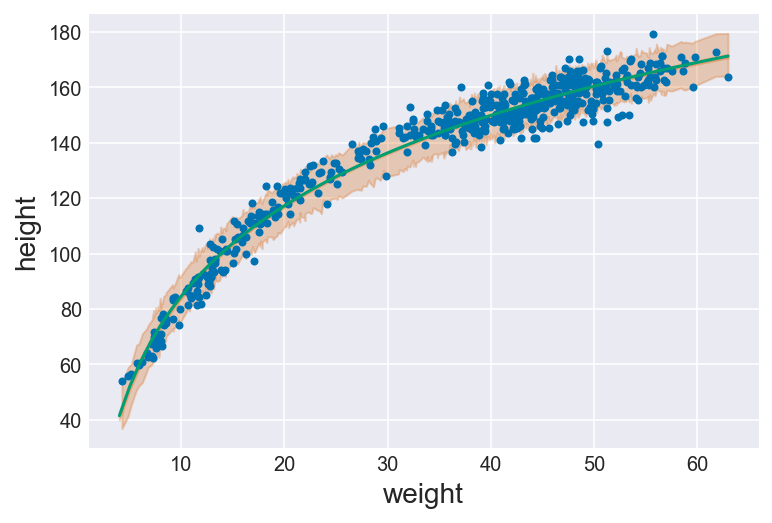

In [36]:
# We reuse the same chart but now with the new data
weight_seq = np.arange(int(d_f.weight.min()), int(d_f.weight.max())+2)

mu_pred_list=[]

for w in weight_seq:
    mu_pred_list.append(trace_4h3['alpha'] + trace_4h3['beta'] * np.log(w))
    
mu_mean_list=[x.mean() for x in mu_pred_list]
mu_hdp_y1=[pm.hpd(x)[0] for x in mu_pred_list]
mu_hdp_y2=[pm.hpd(x)[1] for x in mu_pred_list]

# get prediction hpd
idx = np.argsort(d_f.weight.values)
height_pred = pm.sample_ppc(trace_4h3, 200, m_4h3)
height_pred_hpd = pm.hpd(height_pred['height'],alpha=0.11)
height_pred_hpd=height_pred_hpd[idx]
height_pred_hpd_y1=[x[0] for x in height_pred_hpd]
height_pred_hpd_y2=[x[1] for x in height_pred_hpd]
weight_sorted=d_f.weight.values[idx]

# Plot
plt.plot(d_f.weight, d_f.height, '.') # raw data
plt.plot(weight_seq, mu_mean_list) # regression line
plt.fill_between(weight_seq, mu_hdp_y1, mu_hdp_y2, color='C2', alpha=0.25) # mean 0.5 hdpi
plt.fill_between(weight_sorted, height_pred_hpd_y1, height_pred_hpd_y2, color='C2', alpha=0.25) # pred 0.89 hdpi

plt.xlabel(d_f.columns[1], fontsize=14)
plt.ylabel(d_f.columns[0], fontsize=14);

# This looks like a much better model